# Mass conversion between different mass definitions
## Mass conversion between spherical overdensity mass definitions

In this notebook, we demonstrates how to convert the mass and concentration between various mass definitions (going from $200m$ to $500c$ in this example), and related functionalities, using both the object-oriented and functional interfaces of the code.

In [1]:
import os

os.environ[
    "CLMM_MODELING_BACKEND"
] = "ccl"  # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)
import clmm
import numpy as np
import matplotlib.pyplot as plt

We define a cosmology first:

In [2]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

## Create a `CLMM` Modeling object

### Define a mass profile for a given SOD definition

We define halo parameters following the $200m$ overdensity definition:
1. the mass $M_{200m}$ 
2. the concentration $c_{200m}$

In [3]:
# first SOD definition
M1 = 1e14
c1 = 3
massdef1 = "mean"
delta_mdef1 = 200
# cluster redshift
z_cl = 0.4

In [4]:
# create a clmm Modeling object for each profile parametrisation
nfw_def1 = clmm.Modeling(massdef=massdef1, delta_mdef=delta_mdef1, halo_profile_model="nfw")
her_def1 = clmm.Modeling(massdef=massdef1, delta_mdef=delta_mdef1, halo_profile_model="hernquist")
ein_def1 = clmm.Modeling(massdef=massdef1, delta_mdef=delta_mdef1, halo_profile_model="einasto")

# set the properties of the profiles
nfw_def1.set_mass(M1)
nfw_def1.set_concentration(c1)
nfw_def1.set_cosmo(cosmo)

her_def1.set_mass(M1)
her_def1.set_concentration(c1)
her_def1.set_cosmo(cosmo)

ein_def1.set_mass(M1)
ein_def1.set_concentration(c1)
ein_def1.set_cosmo(cosmo)

## Compute the enclosed mass in a given radius
Calculate the enclosed masses within r with the class method `eval_mass_in_radius`. The calculation can also be done in the functional interface with `compute_profile_mass_in_radius`.

The enclosed mass is calculated as
$$
M(<\text{r}) = M_{\Delta}\;\frac{f\left(\frac{\text{r}}{r_{\Delta}/c_{\Delta}}\right)}{f(c_{\Delta})},
$$

where $f(x)$ for the different models are

- $\text{NFW}:\quad \ln(1+x)-\frac{x}{1+x}$
- $\text{Einasto}:\quad \gamma\left(\frac{3}{\alpha}, \frac{2}{\alpha}x^{\alpha}\right)\quad \; (\gamma\text{ is the lower incomplete gamma function},\; \alpha\text{ is the index of the Einasto profile})$
- $\text{Hernquist}:\quad \left(\frac{x}{1+x}\right)^2$


In [5]:
r = np.logspace(-2, 0.4, 100)
# object oriented
nfw_def1_enclosed_oo = nfw_def1.eval_mass_in_radius(r3d=r, z_cl=z_cl)
her_def1_enclosed_oo = her_def1.eval_mass_in_radius(r3d=r, z_cl=z_cl)
ein_def1_enclosed_oo = ein_def1.eval_mass_in_radius(r3d=r, z_cl=z_cl)

# functional
nfw_def1_enclosed = clmm.compute_profile_mass_in_radius(
    r3d=r,
    redshift=z_cl,
    cosmo=cosmo,
    mdelta=M1,
    cdelta=c1,
    massdef=massdef1,
    delta_mdef=delta_mdef1,
    halo_profile_model="nfw",
)
her_def1_enclosed = clmm.compute_profile_mass_in_radius(
    r3d=r,
    redshift=z_cl,
    cosmo=cosmo,
    mdelta=M1,
    cdelta=c1,
    massdef=massdef1,
    delta_mdef=delta_mdef1,
    halo_profile_model="hernquist",
)
ein_def1_enclosed = clmm.compute_profile_mass_in_radius(
    r3d=r,
    redshift=z_cl,
    cosmo=cosmo,
    mdelta=M1,
    cdelta=c1,
    massdef=massdef1,
    delta_mdef=delta_mdef1,
    halo_profile_model="einasto",
    alpha=ein_def1.get_einasto_alpha(z_cl),
)

Sanity check: comparison of the results given by the object-oriented and functional interface

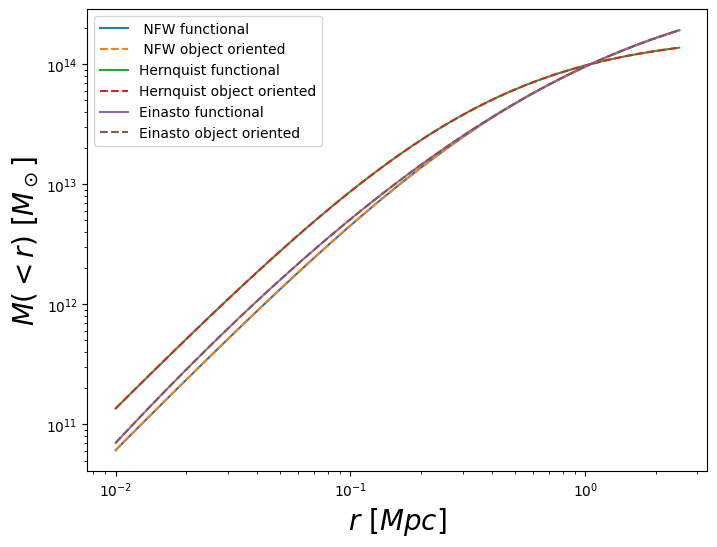

In [6]:
fig = plt.figure(figsize=(8, 6))
fig.gca().loglog(r, nfw_def1_enclosed, label=" NFW functional")
fig.gca().loglog(r, nfw_def1_enclosed_oo, ls="--", label=" NFW object oriented")
fig.gca().loglog(r, her_def1_enclosed, label="Hernquist functional")
fig.gca().loglog(r, her_def1_enclosed_oo, ls="--", label="Hernquist object oriented")
fig.gca().loglog(r, ein_def1_enclosed, label="Einasto functional")
fig.gca().loglog(r, ein_def1_enclosed_oo, ls="--", label="Einasto object oriented")
fig.gca().set_xlabel(r"$r\ [Mpc]$", fontsize=20)
fig.gca().set_ylabel(r"$M(<r)\ [M_\odot]$", fontsize=20)
fig.gca().legend()
plt.show()

## Compute the spherical overdensity radius
We can also compute the spherical overdensity radius, $r_{200m}$ with `eval_rdelta` (resp. `compute_rdelta`) in the object oriented (resp. functional) interface as follows:

In [7]:
## OO interface
r200m_oo = nfw_def1.eval_rdelta(z_cl)

# functional interface
r200m = clmm.compute_rdelta(
    mdelta=M1, redshift=z_cl, cosmo=cosmo, massdef=massdef1, delta_mdef=delta_mdef1
)

print(f"r200m_oo = {r200m_oo} Mpc")
print(f"r200m = {r200m} Mpc")

r200m_oo = 1.056418142453307 Mpc
r200m = 1.056418142453307 Mpc


## Conversion to another SOD definition (here we choose 500c)


In [8]:
# New SOD definition
massdef2 = "critical"
delta_mdef2 = 500

To find $M_2$ and $c_2$ of the second SOD definition, we solve the system of equations:
- $M_{M_1, c_1}(r_1) = M_{M_2, c_2}(r_1)$
- $M_{M_1, c_1}(r_2) = M_{M_2, c_2}(r_2)$

where $M_{M_i, c_i}(r)$ is the mass enclosed within a sphere of radius $r$ specified by the overdensity mass $M_i$ and concentration $c_i$. Here, $r_i$ is chosen to be the overdensity radius $r_{\Delta_i}$ of the $i$th overdensity definition, which is calculated with
$$
r_{\Delta_i} = \left(\frac{3M_{\Delta_i}}{4\pi \Delta_i \rho_{\text{bckgd},i}}\right)^{1/3}
$$
By identifying $M_{M_i, c_i}(r_i) = M_{\Delta_i}$ we now have two equations with two unknowns, $M_2$ and $c_2$:
- $M_1 = M_{M_2, c_2}(r_1)$
- $M_{M_1, c_1}(r_2) = M_2$

The conversion can be done by the `convert_mass_concentration` method of a modeling object and the output is the mass and concentration in the second SOD definition.

In [9]:
M2_nfw_oo, c2_nfw_oo = nfw_def1.convert_mass_concentration(
    z_cl=z_cl, massdef=massdef2, delta_mdef=delta_mdef2
)
M2_her_oo, c2_her_oo = her_def1.convert_mass_concentration(
    z_cl=z_cl, massdef=massdef2, delta_mdef=delta_mdef2
)
M2_ein_oo, c2_ein_oo = ein_def1.convert_mass_concentration(
    z_cl=z_cl, massdef=massdef2, delta_mdef=delta_mdef2
)

print(f"NFW: M2 = {M2_nfw_oo:.2e} M_sun, c2 = {c2_nfw_oo:.2f}")
print(f"HER: M2 = {M2_her_oo:.2e} M_sun, c2 = {c2_her_oo:.2f}")
print(f"EIN: M2 = {M2_ein_oo:.2e} M_sun, c2 = {c2_ein_oo:.2f}")

NFW: M2 = 4.33e+13 M_sun, c2 = 1.33
HER: M2 = 6.48e+13 M_sun, c2 = 1.52
EIN: M2 = 4.36e+13 M_sun, c2 = 1.34


Similarly, there is functional interface to do the conversion (only showing it for NFW below)

In [10]:
M2, c2 = clmm.convert_profile_mass_concentration(
    mdelta=M1,
    cdelta=c1,
    redshift=z_cl,
    cosmo=cosmo,
    massdef=massdef1,
    delta_mdef=delta_mdef1,
    halo_profile_model="nfw",
    massdef2=massdef2,
    delta_mdef2=delta_mdef2,
)
print(f"NFW: M2 = {M2_nfw_oo:.2e} M_sun, c2 = {c2_nfw_oo:.2f}")

NFW: M2 = 4.33e+13 M_sun, c2 = 1.33


## Check conversion by looking at the enclosed mass

To test the conversion method, we plot the relative difference for the enclosed mass between the two mass definitions.
    $$
    \left|\frac{M_{M_2, c_2}(<r)}{M_{M_1, c_1}(<r)}-1\right|
    $$

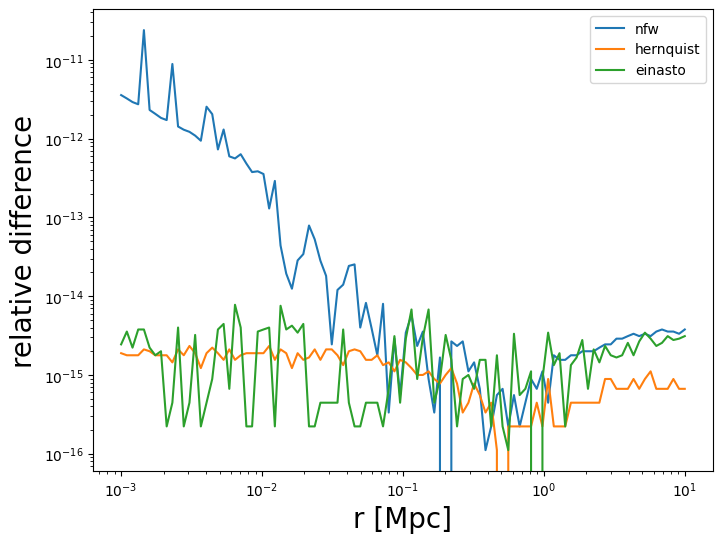

In [11]:
r = np.logspace(-3, 1, 100)
nfw_def2_enclosed = clmm.compute_profile_mass_in_radius(
    r3d=r,
    redshift=z_cl,
    cosmo=cosmo,
    mdelta=M2,
    cdelta=c2,
    massdef=massdef2,
    delta_mdef=delta_mdef2,
    halo_profile_model="nfw",
)
her_def2_enclosed = clmm.compute_profile_mass_in_radius(
    r3d=r,
    redshift=z_cl,
    cosmo=cosmo,
    mdelta=M2_her_oo,
    cdelta=c2_her_oo,
    massdef=massdef2,
    delta_mdef=delta_mdef2,
    halo_profile_model="hernquist",
)
ein_def2_enclosed = clmm.compute_profile_mass_in_radius(
    r3d=r,
    redshift=z_cl,
    cosmo=cosmo,
    mdelta=M2_ein_oo,
    cdelta=c2_ein_oo,
    massdef=massdef2,
    delta_mdef=delta_mdef2,
    halo_profile_model="einasto",
    alpha=ein_def1.get_einasto_alpha(z_cl),
)

fig2 = plt.figure(figsize=(8, 6))
fig2.gca().loglog(
    r, abs(nfw_def2_enclosed / nfw_def1.eval_mass_in_radius(r, z_cl) - 1), ls="-", label="nfw"
)
fig2.gca().loglog(
    r, abs(her_def2_enclosed / her_def1.eval_mass_in_radius(r, z_cl) - 1), ls="-", label="hernquist"
)
fig2.gca().loglog(
    r, abs(ein_def2_enclosed / ein_def1.eval_mass_in_radius(r, z_cl) - 1), ls="-", label="einasto"
)
fig2.gca().set_xlabel("r [Mpc]", fontsize=20)
fig2.gca().set_ylabel(r"relative difference", fontsize=20)
fig2.gca().legend()
plt.show()